# Lane road detection



For road lane detection we need:

- convert image to grayscale.

- make image darker ( sumazina kontrasta nuo nuspalvintu kelio daliu ).

- convert image to  HLScolor space (Hue, Lightness, Saturation).

- isolate yellow color from HLS for getting mask (for yellow lines).

- isolate white color from HLS (for white lines).

- bitwise "OR"  for yellow and white masks for getting common mask

- bitwise "AND" for mask and darker_image

- apply Gaussian blur.

- apply Canny edge detector (thresholdus nustatom bandymu budu).

- Region of interest (leidzia nuimti nereikalingus krastus, kuriuos nustate Canny detector

- Hough lines.

- average and extrapolate Hough lines; (ir nupiesti jas ant pavaikslelio)

Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:

- cv2.inRange() for color selection

- cv2.fillPoly() for regions selection

- cv2.line() to draw lines on an image given endpoints

- cv2.addWeighted() to coadd / overlay two images cv2.cvtColor() to grayscale or change color cv2.imwrite() to output images to file

- cv2.bitwise_and() to apply a mask to an image

https://github.com/nachiket273/Self_Driving_Car

https://github.com/nachiket273/Self_Driving_Car/blob/c76813c282e4ccff50bf3b8732b0134f7f005197/CarND-LaneLines-P1/test_images/solidWhiteRight.jpg

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

#importing some useful packages
import cv2
from helper import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import math

from pathlib import Path
from PIL import Image

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


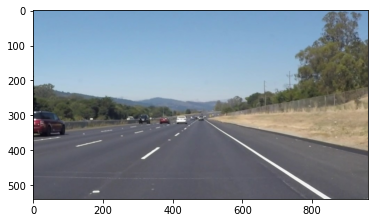

In [ ]:
image = mpimg.imread('/content/gdrive/My Drive/Final_project/test_data/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

### Color selection

In [ ]:
original_img = np.copy(image)
img = np.copy(image)

**Make original image gray**



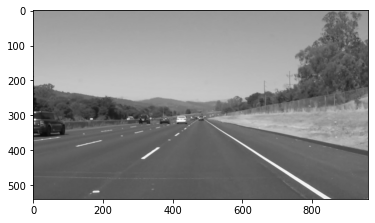

In [ ]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)

plt.imshow(gray_img)

** Darker image **



In [ ]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    darker = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, darker)

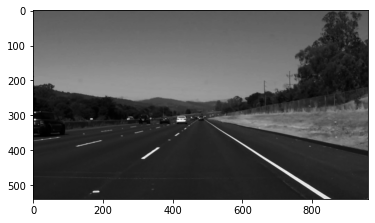

In [ ]:
darkened_img = adjust_gamma(gray_img, 0.5) 
plt.imshow(darkened_img)

## RGB Color Space - Color Selction

In [ ]:
def isolate_color_mask(img, low_thresh, high_thresh):
    assert(low_thresh.all() >=0  and low_thresh.all() <=255)
    assert(high_thresh.all() >=0 and high_thresh.all() <=255)
    return cv2.inRange(img, low_thresh, high_thresh)   #inRange() - for color selection

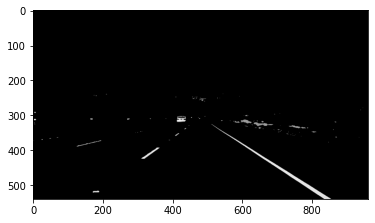

In [ ]:
white_masks = isolate_color_mask(img, np.array([210, 210, 210], dtype=np.uint8), 
                                      np.array([255, 255, 255], dtype=np.uint8)) 
yellow_masks = isolate_color_mask(img, np.array([190, 190, 0], dtype=np.uint8), 
                                      np.array([255, 255, 255], dtype=np.uint8)) 
mask = cv2.bitwise_or(white_masks, yellow_masks)
masked_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)  #bitwise_and() to apply a mask to an image
plt.imshow(masked_img)

  **Gaussian Blur**



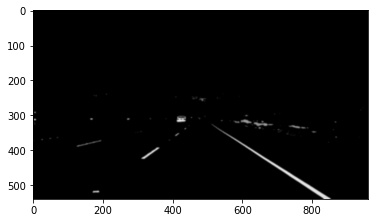

In [ ]:
kernel = 7
blurred_img = cv2.GaussianBlur(masked_img, (kernel, kernel), 0) 
plt.imshow(blurred_img)

**Canny Edge Detector**



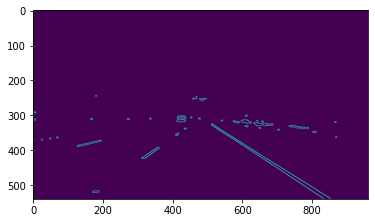

In [ ]:
low_threshold, high_threshold = 70, 140
canny_img = cv2.Canny(blurred_img, low_threshold, high_threshold)   
plt.imshow(canny_img)

**  Area of interest**



In [ ]:
def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.6, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)   #fillPoly() - for region selection
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)

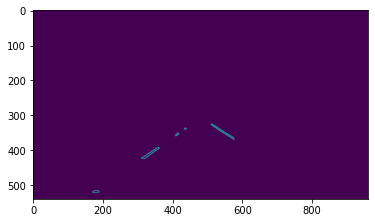

In [ ]:
aoi_img = get_aoi(canny_img)
plt.imshow(aoi_img)

 **Hough Transform Line Detection**



In [ ]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)  # line() - to draw lines on an image given endpoints
            
    return img

def get_hough_lines(img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=300):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

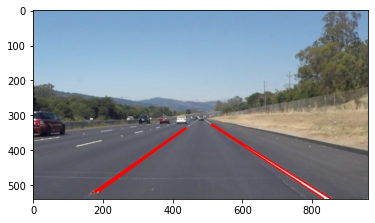

In [ ]:
lines = []
lines = get_hough_lines(aoi_img) 
hough_lines_imgs = draw_lines(original_img, lines)   
plt.imshow(hough_lines_imgs)